1. Duplicates analysis
2. Nulls
3. Dates analysis: (outliers,etc)
4. Orders analysis (outliers,etc)

In [1]:
# Importing packages:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


%matplotlib inline
pd.options.display.max_columns = None

In [2]:
# Defining the search path of the file, the name and the separator:

file_path = "../../data/01_raw/"
file_name = "b2-transactions.csv" #'b2-transactions_sample.csv' 
exit_path = "../../data/02_intermediate/"
original_file_path = file_path + "b2.txt"

# Column names
col_names = ["product_id",
          "description",
          "order_date",
          "section",
          "BmUP",
          "VeUp",
          "CzUP",
          "AaUP",
          "SeUP",
          "JPUP",
          "RzUP",
          "AeUP",
          "LiUP",
          "EnUP",
          "GoUP",
          "GrUP",
          "AnUP",
          "MoUP",
          "PoUP",
          "MsUP",
          "ViUP",
          "ZiUO",
          "GeUP"]
filtered_file_name="c1-filtered_transactions.csv"

sep=";"

In [3]:
target_products_file_name = exit_path + 'filtered_transactions_not_clean.csv' 


In [4]:
df_transactions_filtered = pd.read_csv(target_products_file_name, sep = sep)

In [5]:
df_transactions_filtered.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
0,100.0,CROISANTS,1/1/2008 0:00:00,0,VeUp,"20,00",croissant,croissant simple
1,182.0,PALMERAS DE TRUFA,1/1/2008 0:00:00,0,VeUp,"4,00",palmera de trufa,palmera chocolate
2,101.0,CROISSANT,1/1/2008 0:00:00,0,VeUp,"0,00",croissant,croissant simple
3,103.0,CROISSANT PETIT,1/1/2008 0:00:00,0,VeUp,"18,00",croissant petit,croissant petit
4,112.0,TORTELES,1/1/2008 0:00:00,0,VeUp,"60,00",torteles,tortel


In [6]:
df_transactions_filtered.shape

(967993, 8)

In [7]:
df_transactions_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967993 entries, 0 to 967992
Data columns (total 8 columns):
product_id                   967993 non-null float64
description                  967993 non-null object
order_date                   967993 non-null object
section                      967993 non-null int64
store                        967993 non-null object
units_ordered                967679 non-null object
desc_normalized              967993 non-null object
target_names_prod_by_prod    967993 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 59.1+ MB


"order_date" should be date-type but is not, and "units_ordered" should be numeric, but they are not, and there are some nulls... Lets treat the nulls before parsing to the right types. 

Before continuing, lets parse the dataframe to the right column types:

# Parsing column types

### Parsing column "order_date"

In [8]:
# Parsing "order_date" to date type 
df_transactions_filtered["order_date"] = pd.to_datetime(df_transactions_filtered["order_date"])

In [9]:
df_transactions_filtered.head(2)

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
0,100.0,CROISANTS,2008-01-01,0,VeUp,"20,00",croissant,croissant simple
1,182.0,PALMERAS DE TRUFA,2008-01-01,0,VeUp,"4,00",palmera de trufa,palmera chocolate


Before cleaning column "units_ordered" we need to clean the null values. Then we will be able to parse it to the right numeric type, which is int.

## NULLs Analysis


In [10]:
df_transactions_filtered.isnull().sum()

product_id                     0
description                    0
order_date                     0
section                        0
store                          0
units_ordered                314
desc_normalized                0
target_names_prod_by_prod      0
dtype: int64

As we saw before, there are only nulls in "units_ordered". The good news is that it does seem to be many of them, lets have a look at it before we decide what to do to them:

After some debate, messy EDA, and careful consideration we decided to eliminate the lines for the following reasons:

1) It is possible that these lines constitute "duplicates" (duplicated in all but their values) for lines that hold a value. If this is the case, these lines would be treated as duplicates in the next step of the quality checks (in which we will see that dropping duplicates is the right move).

2) In case that these lines are not duplicated in the rest of the dataset, removing them will make no difference because we currently don't have the real value of number of units placed in the order, so, when the time comes and we will check for missing value in the series, we will appropriately deal with the matter.

In [11]:
# Proving point 1: lines with nulls may be due to duplicates 
df_original = pd.read_csv(original_file_path, sep = sep, encoding = "ISO-8859-1",names = col_names )
df_original[(df_original["order_date"]=="1/1/2009 0:00:00")&(df_original["description"].str.contains("PALMERAS DE TRUFA"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
774282,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"2,00","5,00","2,00","2,00","8,00","3,00","2,00","0,00","0,00","3,00","2,00","4,00","4,00","3,00","0,00","0,00","0,00","0,00","0,00"
781175,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","5,00","0,00","0,00","0,00"


As mentioned above, the smartest option is to eliminate lines with NaN in the unit ordered: 

In [12]:
df_transactions_filtered_nan_removed = df_transactions_filtered.dropna()

In [13]:
# Check
df_transactions_filtered.shape[0] - 314 == df_transactions_filtered_nan_removed.shape[0]


True

### Parsing column "units_ordered" to int

In [14]:
df_transactions_filtered_nan_removed["units_ordered"]  = df_transactions_filtered_nan_removed["units_ordered"].str.split(",").apply(lambda l: int(l[0]))

/home/mrnogues/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
df_transactions_filtered_nan_removed.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
0,100.0,CROISANTS,2008-01-01,0,VeUp,20,croissant,croissant simple
1,182.0,PALMERAS DE TRUFA,2008-01-01,0,VeUp,4,palmera de trufa,palmera chocolate
2,101.0,CROISSANT,2008-01-01,0,VeUp,0,croissant,croissant simple
3,103.0,CROISSANT PETIT,2008-01-01,0,VeUp,18,croissant petit,croissant petit
4,112.0,TORTELES,2008-01-01,0,VeUp,60,torteles,tortel


In [16]:
df_transactions_filtered_nan_removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 967679 entries, 0 to 967992
Data columns (total 8 columns):
product_id                   967679 non-null float64
description                  967679 non-null object
order_date                   967679 non-null datetime64[ns]
section                      967679 non-null int64
store                        967679 non-null object
units_ordered                967679 non-null int64
desc_normalized              967679 non-null object
target_names_prod_by_prod    967679 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 66.4+ MB


Voila! the types look as they should be looking, and the nulls have been treated. 

# Duplicates Analysis

Lets see if we have any duplicates:

In [17]:
df_transactions_filtered_nan_removed.duplicated().sum() 

120340

Wow! this was unexpected 120.323 duplicates... We need to have a deeper look:

In [18]:
duplicates = df_transactions_filtered_nan_removed[df_transactions_filtered_nan_removed.duplicated()]
duplicates

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
261,182.0,PALMERAS DE TRUFA,2009-01-01,0,ZiUO,0,palmera de trufa,palmera chocolate
292,182.0,PALMERAS DE TRUFA,2009-01-01,0,AeUP,0,palmera de trufa,palmera chocolate
325,182.0,PALMERAS DE TRUFA,2009-01-01,0,ViUP,0,palmera de trufa,palmera chocolate
347,182.0,PALMERAS DE TRUFA,2009-01-01,0,LiUP,0,palmera de trufa,palmera chocolate
358,182.0,PALMERAS DE TRUFA,2009-01-01,0,GeUP,0,palmera de trufa,palmera chocolate
...,...,...,...,...,...,...,...,...
967784,4511.0,POSTRE FRESAS Y MASCARPONE,2018-09-09,0,GoUP,0,postres fresas y mascarpone,postre de fresas y mascarpone
967785,459.0,MILHOJAS FRAMBUESA 2º,2018-09-09,0,GoUP,0,milhojas frambuesa 2,milhojas frambuesa
967786,459.0,MILHOJAS FRAMBUESA 2º,2018-09-09,0,GoUP,0,milhojas frambuesa 2,milhojas frambuesa
967787,462.0,MANZANA 2º,2018-09-09,0,GoUP,0,manzana 2,tarta de manzana


Interesting, it seems that all have 0 units ordered, but lets dig more into this:

In [19]:
duplicates["units_ordered"].value_counts()

0     118025
1       1583
2        255
3         71
6         71
4         65
8         50
10        38
5         32
12        21
15        18
25        12
7         12
20        12
18        12
50         9
30         8
14         7
16         7
40         5
11         4
9          4
13         3
24         3
55         2
22         2
26         2
35         2
70         1
90         1
45         1
64         1
60         1
Name: units_ordered, dtype: int64

Unfortunately, it seems that not all the duplicates are 0, otherwise we could have deleted the duplicates as they don't add any value. However we now need to find out a bit more the ones greater than 0. 

Lets explore the original file to see what could have happened:

Lets take for example the duplicate with "units_ordered" = 70:

In [20]:
duplicates[duplicates["units_ordered"]==70]

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
396521,112.0,TORTELES,2016-02-20,0,VeUp,70,torteles,tortel


Lets now search for this specific row in the original dataset that the client gave us:

In [21]:
df_original[(df_original["order_date"]=="1/1/2009 0:00:00")&(df_original["description"].str.contains("PALMERAS DE TRUFA"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
774282,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"2,00","5,00","2,00","2,00","8,00","3,00","2,00","0,00","0,00","3,00","2,00","4,00","4,00","3,00","0,00","0,00","0,00","0,00","0,00"
781175,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","5,00","0,00","0,00","0,00"


In [22]:
df_original.duplicated().sum()

5282

In [23]:
df_original[(df_original["order_date"]=="20/2/2016 0:00:00")&(df_original["description"].str.contains("TORTELES"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
1462852,112.0,TORTELES,20/2/2016 0:00:00,0,"40,00","70,00","35,00","60,00","36,00","30,00","16,00","0,00","0,00","30,00","0,00","0,00","20,00","20,00","30,00","0,00","0,00","0,00","17,00"
1462883,112.0,TORTELES,20/2/2016 0:00:00,0,"0,00","70,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


Interesting, the bottom line is empty except for the store "VeUp" that has the value repeated. Coincidence or patter? lets dig a bit more:

In [24]:
# Lets take a random one from 
duplicates[duplicates["units_ordered"]==4].sample()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
72240,100.0,CROISSANT,2018-11-11,0,JPUP,4,croissant,croissant simple


In [25]:
df_original[(df_original["order_date"]=="27/2/2016 0:00:00")&(df_original["description"].str.contains("MILHOJAS"))&(df_original["description"].str.contains("FRAMBUESA"))][["product_id","description","order_date","section","RzUP"]]

,product_id,description,order_date,section,RzUP
1471806,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"1,00"
1471807,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"4,00"
1471808,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"1,00"
1473160,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"4,00"
1473665,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473671,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473694,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473695,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473778,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"


In [26]:
df_original[(df_original["order_date"]=="27/2/2016 0:00:00")&(df_original["description"].str.contains("MILHOJAS"))&(df_original["description"].str.contains("FRAMBUESA"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
1471806,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1471807,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","4,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1471808,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473160,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"3,00","4,00","0,00","5,00","0,00","2,00","4,00","0,00","0,00","1,00","0,00","0,00","3,00","1,00","3,00","0,00","0,00","0,00","0,00"
1473665,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473671,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","3,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473694,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473695,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473778,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","5,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


Ok..., at this point the information was too confusing: One store, in one day has multiple orders; all very similar.. And when that store is compared to the other stores for the same day, its even more confusing... So we decided to meet with the client and ask for clarifications:

These are the conclusions from the meeting:

 - In the original file, there should only be one line per day, if there are more it could mean two things:
     - if the additional line is all 0 except for one store, AND that store has 0 in the main line, it means that they had to manually input their order in the system.
     - if one store has duplicated orders for a given day-product, it means they made a mistake. 
 - Also, if a store orders different quantities of the same product in the same day, its probably an error and they only take the largest order.
 
 The main conclusion from the client is that we can group by Date - product - store and take the largest order to remove duplicates... HOWEVER, before doing this, we need to take into account another situation: One product could have been ordered by a store, in a given day using several different product id / descriptions. If we group by, we may be loosing orders, unless we are very restrictive. 

In [27]:
#Lets take the max value for each line:
df_non_duplicated_lines = df_transactions_filtered_nan_removed.groupby(['product_id', 'description','order_date', 'section', 'store', 'desc_normalized', 'target_names_prod_by_prod']).max().reset_index()

In [28]:
df_non_duplicated_lines.duplicated().sum()

0

Perfect, we don't have duplicates!... Or yes...

Actually, we may still have duplicates, one store could have created duplicates that we have not identified by ordering the same product by two different ID's or using different descriptions.

- If they were using different ID's this could would mainly mean that they intentionally want two different orders (perhaps custom orders, and normal order)

- If they were using different product descriptions, it would probably mean that they introduced the order two times, however lets explore this situation a bit more:


In [29]:
# Lets count the number of times a duplicated line differs only by the raw desciption, and has a value greater than 0:
aux=df_non_duplicated_lines.drop('description', axis=1)
aux2 = aux[aux.duplicated()]
aux2[aux2["units_ordered"]>0]["units_ordered"].shape

(16,)

In [30]:
aux2["units_ordered"].max()

1

OK, so... the total number of times an order of a given store - day - product differs only by the description is 16 times, hence is safe to remove it from the group by

In [37]:
df_non_duplicated_lines = df_transactions_filtered_nan_removed.groupby(['product_id','order_date', 'section', 'store', 'target_names_prod_by_prod'])["units_ordered"].max().reset_index()

In [38]:
df_non_duplicated_lines.head()

,product_id,order_date,section,store,target_names_prod_by_prod,units_ordered
0,45.0,2017-05-05,0,AaUP,postre de fresas y mascarpone,0
1,45.0,2017-05-05,0,AeUP,postre de fresas y mascarpone,0
2,45.0,2017-05-05,0,AnUP,postre de fresas y mascarpone,0
3,45.0,2017-05-05,0,BmUP,postre de fresas y mascarpone,0
4,45.0,2017-05-05,0,CzUP,postre de fresas y mascarpone,0


In [36]:
df_non_duplicated_lines.duplicated().sum()

0

In [39]:
df_non_duplicated_lines.shape

(742808, 6)

# Data quality:


## 1. File Shape (one line per day-store-product)

The dataset should contain only one line per product, date, and store. However, we already know that one product could have been ordered by given store, in a given day with several products ID's. 

The expectations is that there should around 3 orders of the same product (same day, same store), lets check it:

In [57]:
# Calculate number of orders by a store in a given day and product that are greater than 2:
aux = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["product_id"].count()
aux[aux>2].count()

1007

In [58]:
# Calculate number of orders by a store in a given day and product that are greater than 2:
aux = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["product_id"].count()
aux[aux>2].max()

4

Cool! this means we can group by and add the values!


In [93]:
df_to_check = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["units_ordered"].sum().reset_index()
df_to_check

,order_date,section,store,target_names_prod_by_prod,units_ordered
0,2008-01-01,0,AaUP,baguette,15
1,2008-01-01,0,AaUP,croissant petit,12
2,2008-01-01,0,AaUP,croissant simple,4
3,2008-01-01,0,AaUP,milhojas frambuesa,1
4,2008-01-01,0,AaUP,mousse tres chocolates,0
...,...,...,...,...,...
654569,2019-12-09,0,ZiUO,milhojas frambuesa,0
654570,2019-12-09,0,ZiUO,palmera chocolate,1
654571,2019-12-09,0,ZiUO,postre de fresas y mascarpone,6
654572,2019-12-09,0,ZiUO,tarta de manzana,0


In [56]:
# OUTLIERS

In [95]:
df_to_check['units_ordered'].max()

4100

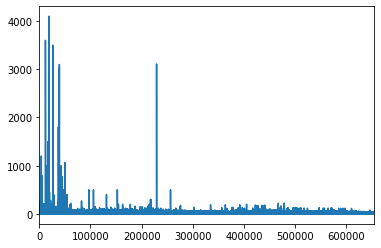

In [96]:
df_to_check['units_ordered'].plot()

In [ ]:
df_to_check

In [90]:
aaa = pd.pivot_table(data=df_for_work, index=['store', 'target_names_prod_by_prod'],)

In [91]:
aaa

section  units_ordered
store target_names_prod_by_prod                            
AaUP  baguette                             0      11.477378
      croissant petit                      0       7.508097
      croissant simple                     0      16.894885
      milhojas frambuesa                   0       2.114654
      mousse tres chocolates               0       0.153201
...                                      ...            ...
ZiUO  palmera chocolate                    0       1.660639
      postre de fresas y mascarpone        0       4.679483
      tarta de manzana                     0       0.000235
      tarta opera                          0       0.000000
      tortel                               0       0.000000

[190 rows x 2 columns]